In [1]:
import torch
import torchvision
import torch.utils.data as data
import matplotlib.pyplot as plt

In [2]:
import os
import pickle
import random
import numpy as np

In [3]:
from mask_cyclegan_vc.model import Generator, Discriminator
from args.cycleGAN_train_arg_parser import CycleGANTrainArgParser
from dataset.vc_dataset import VCDataset
from mask_cyclegan_vc.utils import decode_melspectrogram, get_mel_spectrogram_fig
from logger.train_logger import TrainLogger
from saver.model_saver import ModelSaver

C:\Users\Lewis\AppData\Local\Programs\Python\Python36\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [4]:
parser = CycleGANTrainArgParser()

In [5]:
args = parser.parse_args(args=[])

----------------- Options ---------------
               batch_size: 1                             
                 ckpt_dir: /home/results/debug\ckpts     
           continue_train: False                         
        cycle_loss_lambda: 10                            
              decay_after: 10000.0                       
                   device: cuda                          
         discriminator_lr: 0.0001                        
          epochs_per_plot: 2                             
          epochs_per_save: 1                             
             generator_lr: 0.0002                        
                  gpu_ids: ['cuda:0']                    
     identity_loss_lambda: 5                             
                  isTrain: True                          
               load_epoch: 8                             
                       lr: 0.0005                        
                max_ckpts: 3                             
             max_mask_len: 25 

In [6]:
_args = vars(args)

for n in _args:
    globals()[n] = _args[n]
    print(n, _args[n])

name debug
batch_size 1
save_dir /home/results/
seed 2
gpu_ids ['cuda:0']
steps_per_print 100
epochs_per_save 1
start_epoch 1
load_epoch 8
num_epochs 50
lr 0.0005
decay_after 10000.0
max_ckpts 3
continue_train False
sample_rate 16000
speaker_A_id kevin
speaker_B_id lewis
preprocessed_data_dir dataset\preprocess
generator_lr 0.0002
discriminator_lr 0.0001
cycle_loss_lambda 10
identity_loss_lambda 5
epochs_per_plot 2
num_frames 64
num_frames_validation 320
max_mask_len 25
isTrain True
ckpt_dir /home/results/debug\ckpts
device cuda


In [7]:
batch_size = 1

In [8]:
vocoder = torch.hub.load('descriptinc/melgan-neurips', 'load_melgan')

Using cache found in C:\Users\Lewis/.cache\torch\hub\descriptinc_melgan-neurips_master


In [9]:
dataset_A = pickle.load(open(os.path.join(preprocessed_data_dir, speaker_A_id, "%s_normalized.pickle" % speaker_A_id), 'rb'))
dataset_A_norm_stats = np.load(os.path.join(preprocessed_data_dir, speaker_A_id, "%s_norm_stat.npz" % speaker_A_id))

In [10]:
dataset_A_mean = dataset_A_norm_stats['mean']
dataset_A_std = dataset_A_norm_stats['std']

In [11]:
dataset_B = pickle.load(open(os.path.join(preprocessed_data_dir, speaker_B_id, "%s_normalized.pickle" % speaker_B_id), 'rb'))
dataset_B_norm_stats = np.load(os.path.join(preprocessed_data_dir, speaker_B_id, "%s_norm_stat.npz" % speaker_B_id))

In [12]:
dataset_B_mean = dataset_B_norm_stats['mean']
dataset_B_std = dataset_B_norm_stats['std']

In [13]:
dataset = VCDataset(datasetA=dataset_A, datasetB=dataset_B, n_frames=num_frames, max_mask_len=max_mask_len)

In [14]:
train_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=False)

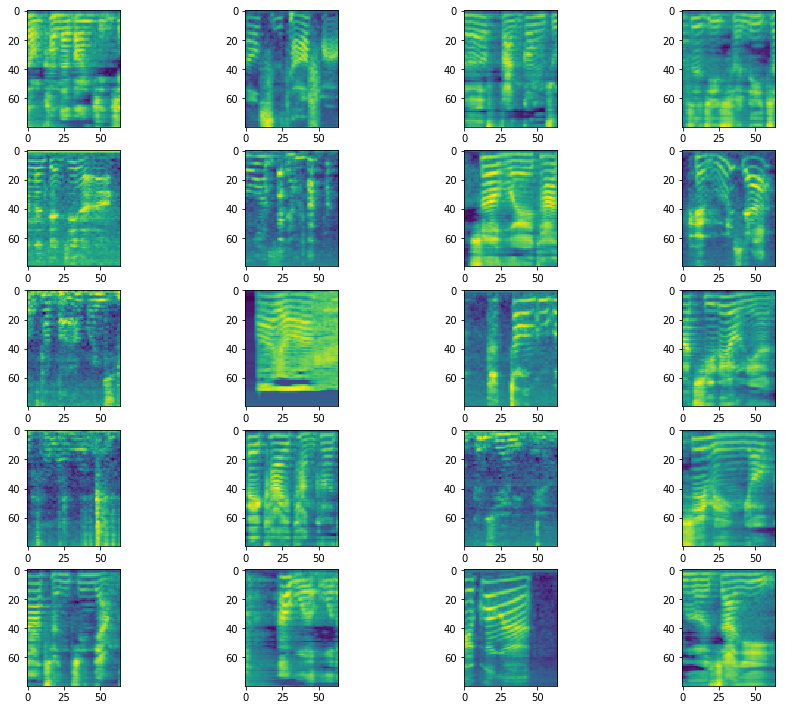

In [15]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    
    for i, (a, ma, b, mb) in enumerate(datset):
        if i == num_samples:
            break
            
        plt.subplot(num_samples/cols + 1, cols, i + 1)
        plt.imshow(a[0])

show_images(train_dataloader)

In [16]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

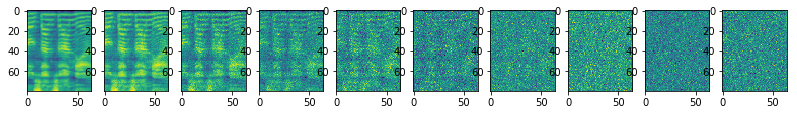

In [17]:
def show_tensor_image(image):
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for idx in range(0, T, stepsize):
        t = torch.Tensor([idx]).type(torch.int64)
        plt.subplot(1, num_images+1, (idx/stepsize) + 1)
        image, noise = forward_diffusion_sample(image, t)

        plt.imshow(image[0])

image = next(iter(train_dataloader))[0]
show_tensor_image(image)

In [18]:
from torch import nn
import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        embeddings = embeddings.to(time.device)
        # TODO: Double check the ordering here
        return embeddings

In [19]:

class GLU(nn.Module):
    """Custom implementation of GLU since the paper assumes GLU won't reduce
    the dimension of tensor by 2.
    """

    def __init__(self):
        super(GLU, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


class PixelShuffle(nn.Module):
    """Custom implementation pf Pixel Shuffle since PyTorch's PixelShuffle
    requires a 4D input (we have 3D inputs).
    """

    def __init__(self, upscale_factor):
        super(PixelShuffle, self).__init__()
        self.upscale_factor = upscale_factor

    def forward(self, x):
        n = x.shape[0]
        c_out = x.shape[1] // 2
        w_new = x.shape[2] * 2
        return x.view(n, c_out, w_new)


class ResidualLayer(nn.Module):
    """ResBlock.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualLayer, self).__init__()

        self.conv1d_layer = nn.Sequential(nn.Conv1d(in_channels=in_channels,
                                                    out_channels=out_channels,
                                                    kernel_size=kernel_size,
                                                    stride=1,
                                                    padding=padding),
                                          nn.InstanceNorm1d(num_features=out_channels,
                                                            affine=True))

        self.conv_layer_gates = nn.Sequential(nn.Conv1d(in_channels=in_channels,
                                                        out_channels=out_channels,
                                                        kernel_size=kernel_size,
                                                        stride=1,
                                                        padding=padding),
                                              nn.InstanceNorm1d(num_features=out_channels,
                                                                affine=True))

        self.conv1d_out_layer = nn.Sequential(nn.Conv1d(in_channels=out_channels,
                                                        out_channels=in_channels,
                                                        kernel_size=kernel_size,
                                                        stride=1,
                                                        padding=padding),
                                              nn.InstanceNorm1d(num_features=in_channels,
                                                                affine=True))

    def forward(self, x):
        h1_norm = self.conv1d_layer(x)
        h1_gates_norm = self.conv_layer_gates(x)
        h1_glu = h1_norm * torch.sigmoid(h1_gates_norm)  # GLU
        h2_norm = self.conv1d_out_layer(h1_glu)
        return x + h2_norm


class DownSampleGenerator(nn.Module):
    """Downsampling blocks of the Generator.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DownSampleGenerator, self).__init__()

        self.convLayer = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=kernel_size,
                                                 stride=stride,
                                                 padding=padding),
                                       nn.InstanceNorm2d(num_features=out_channels,
                                                         affine=True))
        self.convLayer_gates = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                                       out_channels=out_channels,
                                                       kernel_size=kernel_size,
                                                       stride=stride,
                                                       padding=padding),
                                             nn.InstanceNorm2d(num_features=out_channels,
                                                               affine=True))

    def forward(self, x):
        # GLU
        return self.convLayer(x) * torch.sigmoid(self.convLayer_gates(x))



In [20]:
class Generator(nn.Module):
    """modifiy Generator of MaskCycleGAN-VC
    """

    def __init__(self, input_shape=(80, 64), residual_in_channels=256):
        super(Generator, self).__init__()
        Cx, Tx = input_shape
        self.Cx = Cx
        self.Tx = Tx

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(Cx),
            nn.Linear(Cx, Cx),
            nn.ReLU()
        )
        
        self.flattened_channels = (Cx // 4) * residual_in_channels

        # 2D Conv Layer
        self.conv1 = nn.Conv2d(in_channels=2,
                               out_channels=residual_in_channels // 2,
                               kernel_size=(5, 15),
                               stride=(1, 1),
                               padding=(2, 7))

        self.conv1_gates = nn.Conv2d(in_channels=2,
                                     out_channels=residual_in_channels // 2,
                                     kernel_size=(5, 15),
                                     stride=1,
                                     padding=(2, 7))

        # 2D Downsampling Layers
        self.downSample1 = DownSampleGenerator(in_channels=residual_in_channels // 2,
                                               out_channels=residual_in_channels,
                                               kernel_size=5,
                                               stride=2,
                                               padding=2)

        self.downSample2 = DownSampleGenerator(in_channels=residual_in_channels,
                                               out_channels=residual_in_channels,
                                               kernel_size=5,
                                               stride=2,
                                               padding=2)

        # 2D -> 1D Conv
        self.conv2dto1dLayer = nn.Conv1d(in_channels=self.flattened_channels,
                                         out_channels=residual_in_channels,
                                         kernel_size=1,
                                         stride=1,
                                         padding=0)
        self.conv2dto1dLayer_tfan = nn.InstanceNorm1d(
            num_features=residual_in_channels, affine=True)

        # Residual Blocks
        self.residualLayer1 = ResidualLayer(in_channels=residual_in_channels,
                                            out_channels=residual_in_channels * 2,
                                            kernel_size=3,
                                            stride=1,
                                            padding=1)
        self.residualLayer2 = ResidualLayer(in_channels=residual_in_channels,
                                            out_channels=residual_in_channels * 2,
                                            kernel_size=3,
                                            stride=1,
                                            padding=1)
        self.residualLayer3 = ResidualLayer(in_channels=residual_in_channels,
                                            out_channels=residual_in_channels * 2,
                                            kernel_size=3,
                                            stride=1,
                                            padding=1)
        self.residualLayer4 = ResidualLayer(in_channels=residual_in_channels,
                                            out_channels=residual_in_channels * 2,
                                            kernel_size=3,
                                            stride=1,
                                            padding=1)
        self.residualLayer5 = ResidualLayer(in_channels=residual_in_channels,
                                            out_channels=residual_in_channels * 2,
                                            kernel_size=3,
                                            stride=1,
                                            padding=1)
        self.residualLayer6 = ResidualLayer(in_channels=residual_in_channels,
                                            out_channels=residual_in_channels * 2,
                                            kernel_size=3,
                                            stride=1,
                                            padding=1)

        # 1D -> 2D Conv
        self.conv1dto2dLayer = nn.Conv1d(in_channels=residual_in_channels,
                                         out_channels=self.flattened_channels,
                                         kernel_size=1,
                                         stride=1,
                                         padding=0)
        self.conv1dto2dLayer_tfan = nn.InstanceNorm1d(
            num_features=self.flattened_channels, affine=True)

        # UpSampling Layers
        self.upSample1 = self.upsample(in_channels=residual_in_channels,
                                       out_channels=residual_in_channels * 4,
                                       kernel_size=5,
                                       stride=1,
                                       padding=2)

        self.glu = GLU()

        self.upSample2 = self.upsample(in_channels=residual_in_channels,
                                       out_channels=residual_in_channels * 2,
                                       kernel_size=5,
                                       stride=1,
                                       padding=2)

        # 2D Conv Layer
        self.lastConvLayer = nn.Conv2d(in_channels=residual_in_channels // 2,
                                       out_channels=1,
                                       kernel_size=(5, 15),
                                       stride=(1, 1),
                                       padding=(2, 7))

    def downsample(self, in_channels, out_channels, kernel_size, stride, padding):
        self.ConvLayer = nn.Sequential(nn.Conv1d(in_channels=in_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=kernel_size,
                                                 stride=stride,
                                                 padding=padding),
                                       nn.InstanceNorm1d(
                                           num_features=out_channels,
                                           affine=True),
                                       GLU())

        return self.ConvLayer

    def upsample(self, in_channels, out_channels, kernel_size, stride, padding):
        self.convLayer = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=kernel_size,
                                                 stride=stride,
                                                 padding=padding),
                                       nn.PixelShuffle(upscale_factor=2),
                                       nn.InstanceNorm2d(
                                           num_features=out_channels // 4,
                                           affine=True),
                                       GLU())
        return self.convLayer

    def forward(self, x, timestep):
        # Conv2d
        t = self.time_mlp(timestep)
        
        _x = torch.ones_like(x)
        x = torch.stack((x * _x, _x), dim=1)
        
        t = t.reshape((batch_size, 1, self.Cx, 1))
        tx = x + t
        
        conv1 = self.conv1(tx) * torch.sigmoid(self.conv1_gates(tx))  # GLU

        # Downsampling
        downsample1 = self.downSample1(conv1)
        downsample2 = self.downSample2(downsample1)

        # Reshape
        reshape2dto1d = downsample2.view(
            downsample2.size(0), self.flattened_channels, 1, -1)
        reshape2dto1d = reshape2dto1d.squeeze(2)

        # 2D -> 1D
        conv2dto1d_layer = self.conv2dto1dLayer(reshape2dto1d)
        conv2dto1d_layer = self.conv2dto1dLayer_tfan(conv2dto1d_layer)

        # Residual Blocks
        residual_layer_1 = self.residualLayer1(conv2dto1d_layer)
        residual_layer_2 = self.residualLayer2(residual_layer_1)
        residual_layer_3 = self.residualLayer3(residual_layer_2)
        residual_layer_4 = self.residualLayer4(residual_layer_3)
        residual_layer_5 = self.residualLayer5(residual_layer_4)
        residual_layer_6 = self.residualLayer6(residual_layer_5)

        # 1D -> 2D
        conv1dto2d_layer = self.conv1dto2dLayer(residual_layer_6)
        conv1dto2d_layer = self.conv1dto2dLayer_tfan(conv1dto2d_layer)

        # Reshape
        reshape1dto2d = conv1dto2d_layer.unsqueeze(2)
        reshape1dto2d = reshape1dto2d.view(reshape1dto2d.size(0), 256, 20, -1)

        # UpSampling
        upsample_layer_1 = self.upSample1(reshape1dto2d)
        upsample_layer_2 = self.upSample2(upsample_layer_1)

        # Conv2d
        output = self.lastConvLayer(upsample_layer_2)
        output = output.squeeze(1)
        return output

In [24]:
@torch.no_grad()
def show_generator_test(model, image):
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for idx in range(0, T, stepsize):
        t = torch.Tensor([idx]).type(torch.int64).to(device)
        input_x, noise = forward_diffusion_sample(image, t, device)
        noise_pred = model(input_x, t)
        plt.subplot(1, num_images+1, (idx/stepsize) + 1)
        #plt.imshow(input_x.cpu().detach().numpy()[0])
        plt.imshow(noise_pred.cpu().detach().numpy()[0])
        
    plt.show()

#show_generator_test(generator_A, real_A)

In [25]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return torch.mean((x_noisy - noise_pred) ** 2)

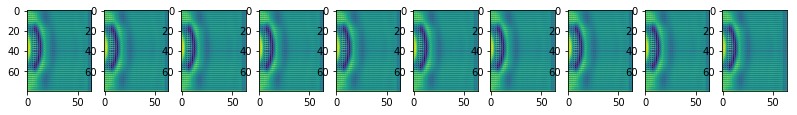

tensor(4.6627, device='cuda:0', grad_fn=<MeanBackward0>)


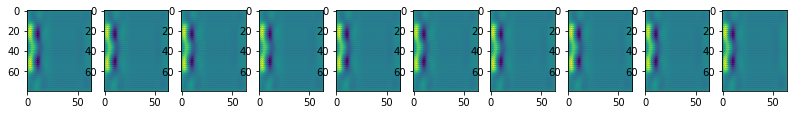

tensor(99.3081, device='cuda:0', grad_fn=<MeanBackward0>)


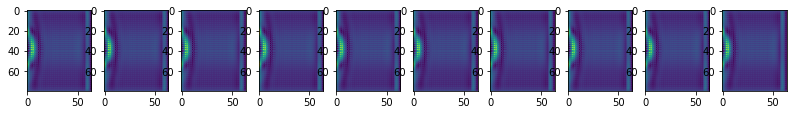

tensor(18.0172, device='cuda:0', grad_fn=<MeanBackward0>)


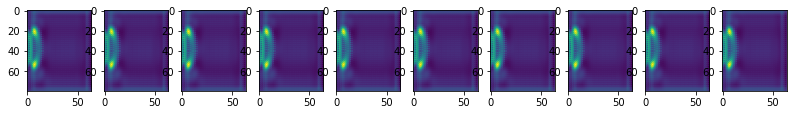

tensor(20.8252, device='cuda:0', grad_fn=<MeanBackward0>)


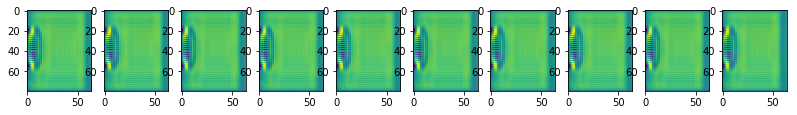

tensor(107.3575, device='cuda:0', grad_fn=<MeanBackward0>)


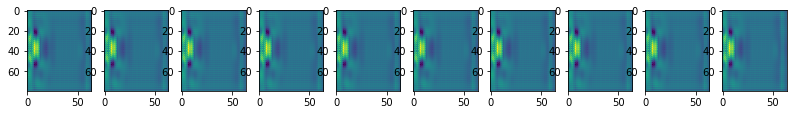

tensor(12.5430, device='cuda:0', grad_fn=<MeanBackward0>)


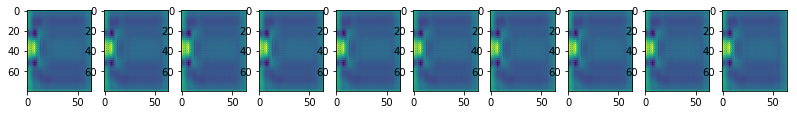

tensor(549.8776, device='cuda:0', grad_fn=<MeanBackward0>)


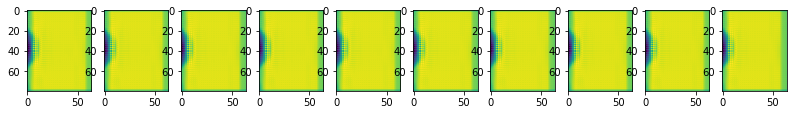

tensor(389.7721, device='cuda:0', grad_fn=<MeanBackward0>)


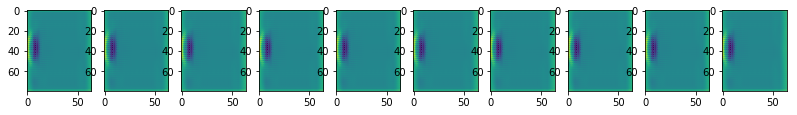

tensor(458.6064, device='cuda:0', grad_fn=<MeanBackward0>)


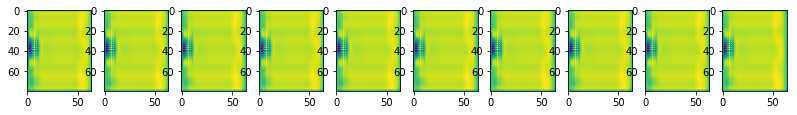

tensor(303.8018, device='cuda:0', grad_fn=<MeanBackward0>)


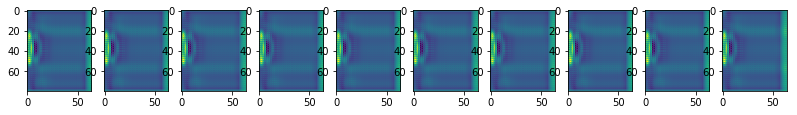

tensor(245.2691, device='cuda:0', grad_fn=<MeanBackward0>)


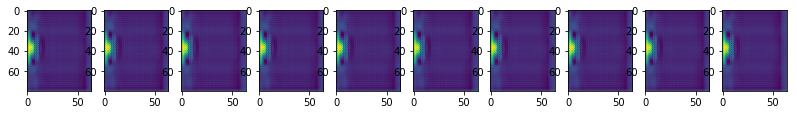

tensor(219.4320, device='cuda:0', grad_fn=<MeanBackward0>)


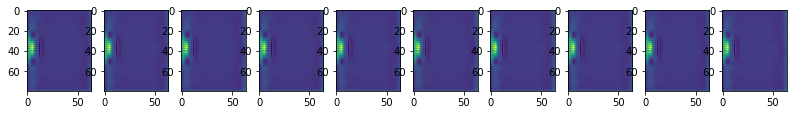

tensor(278.0336, device='cuda:0', grad_fn=<MeanBackward0>)


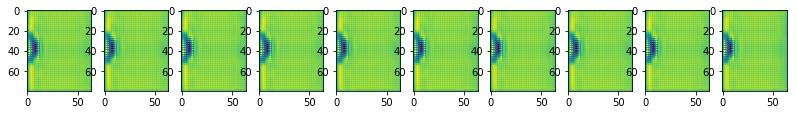

tensor(103.4029, device='cuda:0', grad_fn=<MeanBackward0>)


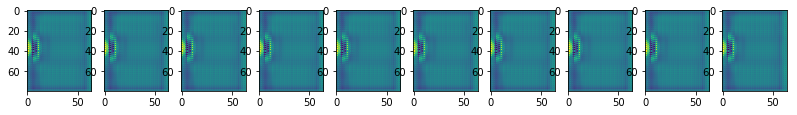

tensor(87.2487, device='cuda:0', grad_fn=<MeanBackward0>)


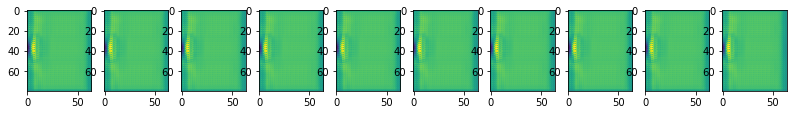

tensor(751.5247, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
generator_A = Generator().to(device)
#generator_B = Generator().to(device)

g_a_params = generator_A.parameters()
generator_a_optimizer = torch.optim.Adam(g_a_params, lr=generator_lr)

i = 0
epochs = 100

for epoch in range(epochs):
    for (real_A, mask_A, real_B, mask_B) in train_dataloader:
        real_A = real_A.to(device, dtype=torch.float)
        
        t = torch.randint(0, T, (batch_size,), device=device).long()
        loss = get_loss(generator_A, real_A, t)
        loss.backward()
        generator_a_optimizer.step()
    
    show_generator_test(generator_A, real_A)
    print(loss)